In [1]:
#https://www.dummies.com/programming/python/plotting-a-sound-file-in-ipython/
import matplotlib.pyplot as plt
#from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
from gurobipy import *
from IPython.display import Audio
import os
import glob
#import untangle

import xml.etree.ElementTree as et
import pandas as pd
import re
from sklearn.metrics import f1_score
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import soundfile

# Functions

In [2]:
# Function for transforming a signal with fourier
def fourier_trans(data, rate, begin_time, end_time): 
    # initialising variables
    tp_count = len(data)
    values = np.arange(int(tp_count/2))
    time_period = tp_count/rate
    frequencies = values/time_period
    
    #at what intervals time points are sampled
    sampling_interval = 1/rate;
    
    #time points
    time = np.arange(begin_time, end_time, sampling_interval);
    
    #Frequency domain representation
    fourier_transform = fft(data)/tp_count #normalized the amplitude
    fourier_transform = fourier_transform[range(int(len(data)/2))] #exclude sampling frequency   
    return frequencies, abs(fourier_transform)

# TODO: Funktion überarbeiten damit man es auch versteht!
def new_fft(data, rate):
    N = len(data)

    # sample spacing
    T = 1.0 / rate
    x = np.linspace(0.0, N*T, N)

    yf = fft(data)
    freq = np.linspace(0.0, 1.0/(2.0*T), N//2)
    ampl = 2.0/N * np.abs(yf[0:N//2])
    return freq, ampl

# Frequency domain representation
def plot_freq_domain(freq, fourier, name):
    plt.figure(figsize=(20,5))
    plt.plot(freq, fourier)
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1400)
    plt.title(name)
    plt.show()

# TODO: Warnung herausgeben wenn bei der Teilung der Samplerate eine Fliesskommazahl entsteht
def easy_downsampling(data, rate, sampl_fac):
    ds_data = []
    for i in range(len(data)):
        if (i%sampl_fac == 0):
            ds_data.append(data[i])
    ds_rate = int(rate/sampl_fac)
    return ds_data, ds_rate

#ToDo: startwert von 0 nicht möglich überarbeiten!!
def snip_wav(data, rate, start_sec, end_sec):
    start_point = int((rate * start_sec)-1)
    end_point = int((rate * end_sec)-1)
    #print('start_point:', start_point)
    #print('end_point:', end_point)
    snip_data = data[start_point:end_point]
    #print(snip_data)  
    return snip_data, rate

# Berechnung Vector target
#def calc_target_vec(pitch):
#    pitch_start = 40
#    #pitch_end = 76
#    pitch_end = pitch_start + 77 #TODO: muss angepasst werden
#    target_vec = []
#    
#    if pitch_start <= pitch <= pitch_end:
#        for pitch_act in range(pitch_start, pitch_end+1):
#            
#            if pitch_act == pitch:
#                target_vec.append(1)
#            else:
#                target_vec.append(0)
#    else:
#        print('Pitch muss innerhalb der Range({} - {})!'.format(pitch_start, pitch_end))
#    
#    return target_vec

def calc_target_vec(pitch):
    pitch_start = 40
    pitch_end = 76
    #pitch_end = pitch_start + 77 #TODO: muss angepasst werden
    combi_vec = []
    for element in pitch:
        pitch_vec = []
        if pitch_start <= element <= pitch_end:
            for pitch_act in range(pitch_start, pitch_end+1):
                if pitch_act == element:
                    pitch_vec.append(1)
                else:
                    pitch_vec.append(0)
            combi_vec.append(pitch_vec)
        else:
            print('Pitch {} muss innerhalb der Range({} - {})!'.format(pitch, pitch_start, pitch_end))
            return[0] * (pitch_end - pitch_start + 1) # for harmonics
    target_vec = [sum(x) for x in zip(*combi_vec)]
    return target_vec

def metric(target_v, approx_v):
    norm_factor = np.linalg.norm(approx_v)
    if (norm_factor != 0):
        norm_v = approx_v/norm_factor
        diff = target_v - norm_v
        diff_sum = np.sum(np.abs(diff))
        return diff_sum
    else:
        print('Der Vektor kann nicht normalisiert werden.')
        return approx_v 
    
def norm_vec(vector):
    norm_factor = np.linalg.norm(vector)
    if (norm_factor != 0):
        norm_v = vector/norm_factor
        return norm_v
    else:
        print('Der Vektor kann nicht normalisiert werden.')
        return vector

## Dataframe 

In [3]:
def read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac):
    dataset = re.search(r'dataset.*\b', path).group(0)
    path_xml = path + "annotation"
    path_wav = path + "audio"  
    df = pd.DataFrame(columns=df_cols)
    
    for xml_file in sorted(glob.glob(os.path.join(path_xml, '*.xml'))):
        tree = et.parse(xml_file)
        root = tree.getroot()
        all_events = []
       
        for globalParam in root.findall('globalParameter'):
            audio_name = globalParam.find('audioFileName').text
            audio_name = audio_name.replace("\\", "")
            
            # Read wav-file
            wav_file = path_wav + '/' + audio_name
            data, rate = soundfile.read(wav_file)

        for transcription in root.findall('transcription'):

            for event in transcription.findall('event'):
                event_data = []
                event_data.append(dataset)
                event_data.append(audio_name)

                for elem in df_cols[len(event_data):]:
                    if event is not None:
                        if event.find(elem) is not None:
                            event_data.append(event.find(elem).text)
                            
                        elif elem == df_cols[3]:
                            onset_sec = event.find('onsetSec').text
                            event_data.append(onset_sec)
                            start_sec = round(offset_sec + float(onset_sec), 3)
                            end_sec = round(start_sec + duration_sec, 3)

                            # Snip and downsampling audio-file
                            data_snip, rate_snip = snip_wav(data, rate, start_sec, end_sec)
                            data_down, rate_down = easy_downsampling(data_snip, rate_snip, sampl_fac)

                            # Calc FFT
                            freq, fourier = new_fft(data_down, rate_down)
                                                       
                        elif elem == 'amplitude':
                            event_data.append(fourier)

                        elif elem == 'frequency':
                            event_data.append(freq)
                        else:
                            event_data.append(None)
                    else:
                        event_data.append(None)

                all_events.append({df_cols[i]: event_data[i] for i, _ in enumerate(df_cols)})
                
        combi_events = mono_poly_detection(all_events)
        df = df.append(pd.DataFrame(combi_events, columns=df_cols), ignore_index=True)
        
    return df

In [4]:
def mono_poly_detection(events):
    
    poly_time = 0.070
    
    dataset = events[0]['dataset']
    audioFileName = events[0]['audio_file_name']
    amp = events[0]['amplitude']
    freq = events[0]['frequency']
    
    onsets = []
    pitches = []
    combi_events = []

    
    for event in events:
        onsets.append(float(event['onset_sec']))
        pitches.append(int(event['pitch']))
        
    pitch_array = [pitches[0]]
    new_onset = onsets[0]
    

    for i in range(len(events)-1):
        if (onsets[i + 1]- onsets[i]) <= poly_time:
            pitch_array.append(pitches[i+1])
            new_onset = onsets[i+1]
            amp = events[i+1]['amplitude']
            freq = events[i+1]['frequency']
            
        else:
            combi_events.append({'dataset': dataset,
                               'audio_file_name': audioFileName,
                               'pitch': pitch_array,
                               'onset_sec': new_onset,
                               'amplitude': amp,
                               'frequency': freq,
                              })
            
            pitch_array = [pitches[i+1]]
            new_onset = onsets[i+1]
            amp = events[i+1]['amplitude']
            freq = events[i+1]['frequency']
            
    combi_events.append({'dataset': dataset,
                   'audio_file_name': audioFileName,
                   'pitch': pitch_array,
                   'onset_sec': new_onset,
                   'amplitude': amp,
                   'frequency': freq,
                  })

    return combi_events

# Init Dataframe

In [5]:
# Set audio snippets and sample compression
offset_sec = 0.01
duration_sec = 0.05
sampl_fac = 4

# Create empty Dataframe
df_cols = ['dataset', 'audio_file_name', 'pitch', 'onset_sec', 'amplitude', 'frequency']
df_ref = pd.DataFrame(columns=df_cols)
df_test = pd.DataFrame(columns=df_cols)

# Create Dataframe with reference tones

In [6]:
%%time
# paths
path_main = "IDMT-SMT-GUITAR_V2/"
path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC/"
#path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC Chords/"

df_ref = read_xml_to_df(path_main_ref, df_cols, offset_sec, duration_sec, sampl_fac)
df_ref.head(10)
#df_ref.pitch

Wall time: 589 ms


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.010434689729110054, 0.007642355853034964, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008730681046195652, 0.0016019660211104261,...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.003316354060518569, 0.004175739354076509, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0010865805805593297, 0.0012861112124336416,...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.004883918209352355, 0.006490007899478263, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
5,dataset1/Fender Strat Clean Neck SC,G53-45105-1111-00006.wav,[45],0.2,"[0.009665890016417572, 0.01239635315092953, 0....","[0.0, 20.045454545454547, 40.09090909090909, 6..."
6,dataset1/Fender Strat Clean Neck SC,G53-45200-1111-00014.wav,[45],0.2,"[0.0013240869494451993, 0.002425232423292276, ...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
7,dataset1/Fender Strat Clean Neck SC,G53-46106-1111-00007.wav,[46],0.2,"[0.003936435865319294, 0.002298465268484752, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
8,dataset1/Fender Strat Clean Neck SC,G53-46201-1111-00015.wav,[46],0.2,"[0.004933122275532156, 0.003532449558060931, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
9,dataset1/Fender Strat Clean Neck SC,G53-47107-1111-00008.wav,[47],0.2,"[0.0020849255548007245, 0.0005009016789155238,...","[0.0, 20.045454545454547, 40.09090909090909, 6..."


In [7]:
# drop duplicate in df_ref
df_ref_unique = pd.DataFrame(columns=df_cols)
 
for index, row in df_ref.iterrows():
    if not df_ref_unique.pitch.str.contains(row.pitch[0], regex=False).any():
        df_ref_unique = df_ref_unique.append(row, ignore_index=True)
df_ref_unique

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.010434689729110054, 0.007642355853034964, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008730681046195652, 0.0016019660211104261,...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.003316354060518569, 0.004175739354076509, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0010865805805593297, 0.0012861112124336416,...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.004883918209352355, 0.006490007899478263, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
5,dataset1/Fender Strat Clean Neck SC,G53-45105-1111-00006.wav,[45],0.2,"[0.009665890016417572, 0.01239635315092953, 0....","[0.0, 20.045454545454547, 40.09090909090909, 6..."
6,dataset1/Fender Strat Clean Neck SC,G53-46106-1111-00007.wav,[46],0.2,"[0.003936435865319294, 0.002298465268484752, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
7,dataset1/Fender Strat Clean Neck SC,G53-47107-1111-00008.wav,[47],0.2,"[0.0020849255548007245, 0.0005009016789155238,...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
8,dataset1/Fender Strat Clean Neck SC,G53-48108-1111-00009.wav,[48],0.2,"[0.004890331323596015, 0.003789645602390845, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
9,dataset1/Fender Strat Clean Neck SC,G53-49109-1111-00010.wav,[49],0.2,"[0.002581167912137681, 0.0007091701274158104, ...","[0.0, 20.045454545454547, 40.09090909090909, 6..."


# Create Dataframe with testdatas

In [8]:
%%time
# paths testdata
# ToDO: Automatisieren #os.listdir(path_main + path_dataset)

path_testdata = [
    path_main + 'dataset1/Fender Strat Clean Neck SC/',
    path_main + 'dataset1/Fender Strat Clean Neck SC Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge+Neck SC/',
    path_main + 'dataset1/Ibanez Power Strat Clean Neck HU/',
    path_main + 'dataset2/']

# dataset2:
# [Errno 2] No such file or directory: 'IDMT-SMT-GUITAR_V2/dataset2/audio/\\AR_A_fret_1-20.wav'
# in xml file den audionamen angepasst AR_A_fret_1-20.wav --> AR_A_fret_0-20.wav
# Alle 0-20 und Lick11
# Gesamthaft mussten 27 von 261 XML-Dateien überarbeitet werden

for path in path_testdata:
    df_act = read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac)
    df_test = df_test.append(df_act, ignore_index=True)
df_test

Wall time: 15.8 s


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2000,"[0.010434689729110054, 0.007642355853034964, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2000,"[0.0008730681046195652, 0.0016019660211104261,...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2000,"[0.003316354060518569, 0.004175739354076509, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2000,"[0.0010865805805593297, 0.0012861112124336416,...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2000,"[0.004883918209352355, 0.006490007899478263, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
...,...,...,...,...,...,...
4448,dataset2,LP_V_vibrato_slow-fast.wav,[60],43.0498,"[0.0024203938850458117, 0.004909077395644729, ...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
4449,dataset2,LP_V_vibrato_slow-fast.wav,[64],49.6065,"[0.005037724539853524, 0.002270726865951755, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
4450,dataset2,LP_V_vibrato_slow-fast.wav,[64],55.5450,"[0.0023865211701047592, 0.002239176098760359, ...","[0.0, 20.045454545454547, 40.09090909090909, 6..."
4451,dataset2,LP_V_vibrato_slow-fast.wav,[69],62.3891,"[0.003183000329611958, 0.002746414155446651, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6..."


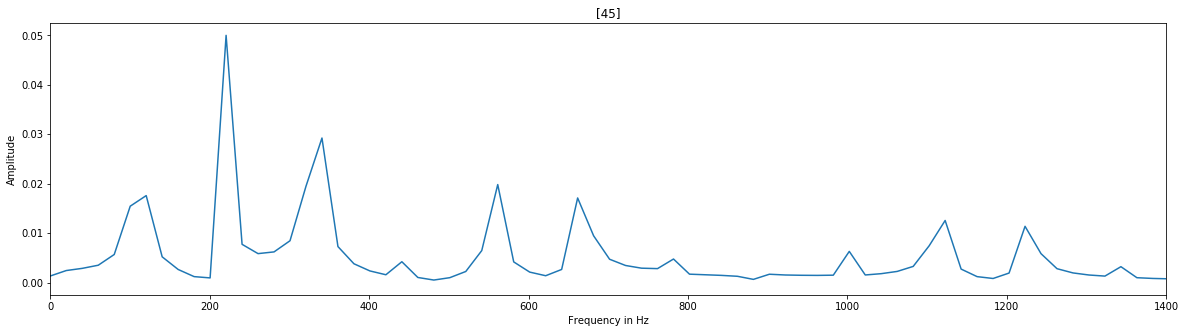

In [9]:
pitch = 6
plot_freq_domain(df_ref.frequency[pitch], df_ref.amplitude[pitch], df_ref.pitch[pitch])

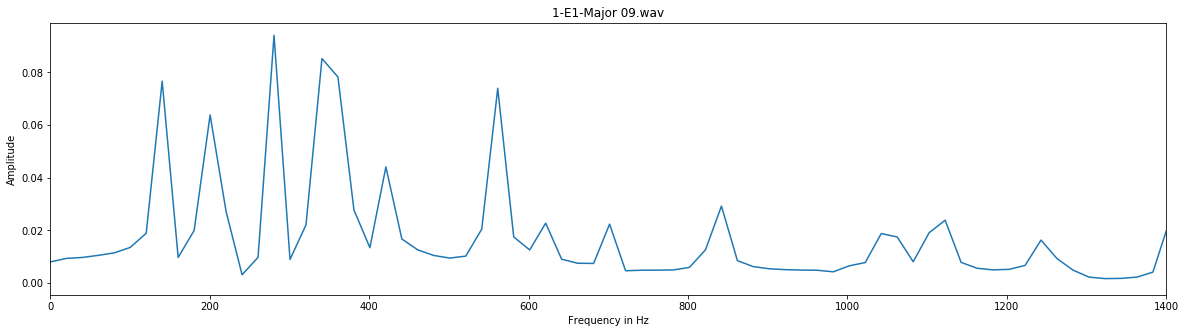

In [10]:
pitch = 87
plot_freq_domain(df_test.frequency[pitch], df_test.amplitude[pitch], df_test.audio_file_name[pitch])

## Histogram of Pitches Distribution

pitch min: 40
pitch max: 92


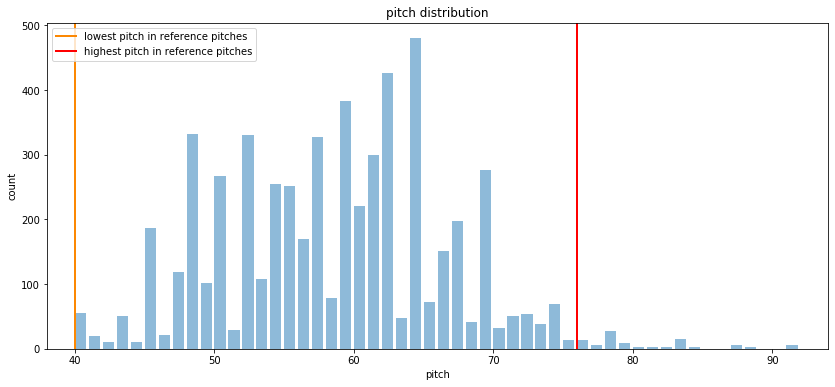

In [11]:
all_pitches_temp = df_test.pitch.tolist()
 
# flatten List
all_pitches = []
for sublist in all_pitches_temp:
    for item in sublist:
        all_pitches.append(item)
        
# plot figure        
plt.figure(figsize=(14,6)) 
bins = np.arange(min(all_pitches), max(all_pitches)+1)
plt.xlim([min(all_pitches)-2, max(all_pitches)+2])
 
    
min_pitch = min(all_pitches)   
max_pitch = max(all_pitches)
print('pitch min:',min_pitch)
print('pitch max:', max_pitch)

ref_min = min(df_ref_unique.pitch)
ref_max = max(df_ref_unique.pitch)

plt.hist(all_pitches, bins = bins, range=[min_pitch,max_pitch], alpha=0.5, width=0.8)
plt.axvline(linewidth=2, color='#fc8803', x=ref_min, label='lowest pitch in reference pitches')
plt.axvline(linewidth=2, color='r', x=ref_max, label='highest pitch in reference pitches')
plt.title('pitch distribution')
plt.xlabel('pitch')
plt.ylabel('count')
plt.legend(loc = 'upper left')

# Gurobi

In [12]:
# Build Model
m = Model('AMt')

lambs = []
for lamb in range(len(df_ref_unique)):
    lambs.append(m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_' + str(lamb)))
m.update()

Academic license - for non-commercial use only


In [13]:
'''
%%time
#Optimize Signal

deviation = 0
approxi_sgn = 0
 
for sgn in range(len(mischsignal)):
#for sgn in range(100):
    for lamb in range(len(lambs)):
        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]
        
    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))
    # deviation wird ausmultipliziert stattdessen die für 'mischsignal[sgn] - approxi_sgn'
    # eine Gurobi-Variable (m.addVar  inkl. constr.) verwenden
    # Überprüfen ob der Betrag der Differenz besser geeignet ist?
print('Deviation is calculated.')
'''

"\n%%time\n#Optimize Signal\n\ndeviation = 0\napproxi_sgn = 0\n \nfor sgn in range(len(mischsignal)):\n#for sgn in range(100):\n    for lamb in range(len(lambs)):\n        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]\n        \n    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))\n    # deviation wird ausmultipliziert stattdessen die für 'mischsignal[sgn] - approxi_sgn'\n    # eine Gurobi-Variable (m.addVar  inkl. constr.) verwenden\n    # Überprüfen ob der Betrag der Differenz besser geeignet ist?\nprint('Deviation is calculated.')\n"

In [14]:
%%time
pred_vec = []

len_lambs = len(lambs)

amplitudes = df_test.amplitude.tolist()


#m.reset()

#for index, row in df_test.iterrows():
for amplitude in amplitudes:
    #mischsignal = row.Amplitude
    mischsignal = amplitude
    len_mischsignal = len(mischsignal)
    #print(row.audioFileName)


    # Schlaufen vertauscht
    cost_function = 0
    approxi_sgn = 0  
    #print(type(cost_function))
    #cost_function = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'CostFunction')
    #approxi_sgn = m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'approxi_sgn')

    for lamb in range(len_lambs):
        la = lambs[lamb]
        note = df_ref_unique.amplitude[lamb]
        

        for sgn in range(len_mischsignal):
            approxi_sgn = la * note[sgn]
            mi = mischsignal[sgn]
            
            
            deviation = mi - approxi_sgn
            #print(type(mi))
            
            cost_function += deviation * deviation
            #cost_function += ((mi - approxi_sgn)*(mi - approxi_sgn))
    #print('Cost Function is created')

    #Params
    m.params.outputflag = 0 # Infotext ausblenden
    #m.params.presolve = 0
    
    m.setObjective(cost_function, GRB.MINIMIZE)
    m.optimize()



    approx_v = []

    for v in m.getVars():
        #print('%s: %g' % (v.varName, v.x))
        approx_v.append(v.x)

    pred_vec.append(approx_v)

Wall time: 38min 27s


In [15]:
df_test['pred_vec'] = pred_vec

# Calculate Pitch Score

In [16]:
# Calc all target vectors
target_pitches = df_test.pitch.array
target_vec = []

for pitch in target_pitches:
    target_vec.append(calc_target_vec(pitch))

df_test['target_vec'] = target_vec
df_test.head()

Pitch [77] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [79] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [77] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [79] muss innerhalb der Range(40 - 76)!
Pitch [80] muss innerhalb der Range(40 - 76)!
Pitch [81] muss innerhalb der Range(40 - 76)!
Pitch [82] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [84] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [87] muss innerhalb der Range(40 - 76)!
Pitch [92] muss innerhalb der Range(40 - 76)!
Pitch [78] muss innerhalb der Range(40 - 76)!
Pitch [83] muss innerhalb der Range(40 - 76)!
Pitch [87] muss innerhalb der Rang

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,pred_vec,target_vec
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.010434689729110054, 0.007642355853034964, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.999999999999998, 0.5486054892300932, 0.6570...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008730681046195652, 0.0016019660211104261,...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.5976666230535015, 0.9999999999999996, 0.960...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.003316354060518569, 0.004175739354076509, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.48480868008014616, 0.6506470758694712, 0.99...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0010865805805593297, 0.0012861112124336416,...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.32017537793681633, 0.4768196305742927, 0.77...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.004883918209352355, 0.006490007899478263, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.5354608382127908, 0.5285490661406032, 0.886...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
pitch_score = []
#vec_target = df_test.pitch.array

for vec in range(len(pred_vec)):
    pitch_score.append(metric(target_vec[vec], pred_vec[vec]))
    
df_test['pitch_score'] = pitch_score
df_test.head()

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,pred_vec,target_vec,pitch_score
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.010434689729110054, 0.007642355853034964, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.999999999999998, 0.5486054892300932, 0.6570...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.320632
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008730681046195652, 0.0016019660211104261,...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.5976666230535015, 0.9999999999999996, 0.960...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.325467
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.003316354060518569, 0.004175739354076509, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.48480868008014616, 0.6506470758694712, 0.99...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.267888
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0010865805805593297, 0.0012861112124336416,...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.32017537793681633, 0.4768196305742927, 0.77...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.002764
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.004883918209352355, 0.006490007899478263, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.5354608382127908, 0.5285490661406032, 0.886...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.400845


# Calculate F1 Score

In [18]:
# thresholding vec_pred
%time
thresholded_vec = []
norm_pred_vec = []
#v_pred = df_test.pred_vec

for j in range(len(pred_vec)):
    thresh_vec = []
    vec = norm_vec(pred_vec[j])
    
    for i in range(len(vec)):
        if vec[i]> 0.24:
            thresh_vec.append(1)
        else:
            thresh_vec.append(0)
            
    thresholded_vec.append(thresh_vec)
    norm_pred_vec.append(vec)
    
df_test['thresholded_vec'] = thresholded_vec
df_test['norm_pred_vec'] = norm_pred_vec

df_test.head()

Wall time: 0 ns


,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,pred_vec,target_vec,pitch_score,thresholded_vec,norm_pred_vec
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,[40],0.2,"[0.010434689729110054, 0.007642355853034964, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.999999999999998, 0.5486054892300932, 0.6570...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.320632,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.45195570362413295, 0.24794537989704898, 0.2..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,[41],0.2,"[0.0008730681046195652, 0.0016019660211104261,...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.5976666230535015, 0.9999999999999996, 0.960...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.325467,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0.25055630873324436, 0.41922419467418565, 0.4..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,[42],0.2,"[0.003316354060518569, 0.004175739354076509, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.48480868008014616, 0.6506470758694712, 0.99...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.267888,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.22470826097987062, 0.30157416510384427, 0.4..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,[43],0.2,"[0.0010865805805593297, 0.0012861112124336416,...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.32017537793681633, 0.4768196305742927, 0.77...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.002764,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.1438112006028742, 0.21417013383658762, 0.34..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,[44],0.2,"[0.004883918209352355, 0.006490007899478263, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.5354608382127908, 0.5285490661406032, 0.886...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.400845,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.2150146117667456, 0.21223918566148284, 0.35..."


In [19]:
#x = df_test.Vec_Pred_Norm[0]
#np.amax(x)
max_val = []
for i in df_test.norm_pred_vec:
    max_val.append(np.amax(i))
print('optimal threshold for binarizing vec pred is: ', min(max_val))

optimal threshold for binarizing vec pred is:  0.2340491151678328


In [20]:
df_test.sort_values(by = 'pitch_score', ascending = False)

,dataset,audio_file_name,pitch,onset_sec,amplitude,frequency,pred_vec,target_vec,pitch_score,thresholded_vec,norm_pred_vec
3384,dataset2,LP_Lick10_MN.wav,"[45, 52, 64, 69, 57, 60]",8.4332,"[0.0035893027333245764, 0.004047869528078583, ...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.5691847225330784, 0.6255909622655869, 0.853...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",10.283896,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.20258068644312413, 0.22265644447442462, 0.3..."
2033,dataset2,FS_Lick10_MN.wav,"[64, 45, 60, 69, 52, 57]",11.9075,"[0.0003878819769707279, 0.004299229460009416, ...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.8194244664228836, 0.7207360860271225, 1.136...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",10.058584,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.23364633545830968, 0.20550685540050342, 0.3..."
666,dataset2,AR_Lick10_KN.wav,"[45, 52, 57, 60, 64, 69]",9.4389,"[0.0023816897385362267, 0.0006469321384717269,...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[1.0021117412934133, 0.8650508050980682, 1.124...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",10.030095,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.22890403745600155, 0.19759634952080168, 0.2..."
3352,dataset2,LP_Lick10_FN.wav,"[45, 57, 52, 60, 64, 69]",9.5020,"[0.005559802919194319, 0.01896499501628533, 0....","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.8911938853944513, 0.7653301673658425, 1.123...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",10.028365,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.22628603206975448, 0.19432755277471953, 0.2..."
651,dataset2,AR_Lick10_FN.wav,"[43, 62, 67, 50, 59, 55]",9.9302,"[0.005449807298356208, 0.009411305560316848, 0...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.8945549732345967, 0.7099852576694837, 0.996...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",10.027712,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.25646725548425114, 0.20355145957141627, 0.2..."
...,...,...,...,...,...,...,...,...,...,...,...
389,dataset1/Ibanez Power Strat Clean Neck HU,G53-69510-1111-00141.wav,[69],0.2070,"[0.0033263054446897645, 0.0013517087653570092,...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.136717339422777, 0.44178100540289156, 0.284...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.947915,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0666410059282425, 0.21534013698875584, 0.13..."
67,dataset1/Fender Strat Clean Neck SC,G53-69510-1111-00063.wav,[69],0.2000,"[0.001548545947973279, 9.816389680132087e-05, ...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.07584936849771581, 0.23830531105243827, 0.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.908324,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.06369671052372058, 0.20012380742272723, 0.1..."
321,dataset1/Ibanez Power Strat Clean Bridge+Neck SC,G53-76612-1111-234.wav,[76],0.2000,"[0.00440437206323596, 0.004182766551273879, 0....","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.06188288603706552, 0.05647151513920834, 0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.880699,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.07519442978446843, 0.0686190262266428, 0.08..."
76,dataset1/Fender Strat Clean Neck SC,G53-75611-1111-00077.wav,[75],0.2000,"[0.0007009091584578805, 0.0006195256131551688,...","[0.0, 20.045454545454547, 40.09090909090909, 6...","[0.032306581691612206, 0.062487614015580624, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2.050351,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.028643089175500354, 0.05540166142297931, 0...."


In [21]:
combi_target_vec = []
for i in df_test.target_vec:
    for elem in i:
        combi_target_vec.append(elem)
#print(target_vecs)

combi_pred_vec = []
for i in df_test.thresholded_vec:
    for elem in i:
        combi_pred_vec.append(elem)
#print(pred_vecs)

# Scores

In [24]:
df_test['mono_poly'] = df_test.pitch.apply(lambda x: len(x))
pitch_score_mono = df_test.loc[df_test.mono_poly == 1].pitch_score.mean()
pitch_score_poly = df_test.loc[df_test.mono_poly > 1].pitch_score.mean()
print('Possible number of Pichtes', df_test.mono_poly.unique())

print('Pitch Score Mono: ', round(pitch_score_mono, 2))
print('Pitch Score Poly: ', round(pitch_score_poly, 2))

Possible number of Pichtes [1 6 5 3 2 4]
Pitch Score Mono:  5.9
Pitch Score Poly:  7.73


In [23]:
print(classification_report(combi_target_vec, combi_pred_vec))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    159168
           1       0.19      0.54      0.28      5593

    accuracy                           0.91    164761
   macro avg       0.59      0.73      0.62    164761
weighted avg       0.96      0.91      0.93    164761

